This will adapt structure window size

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [4]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [5]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [6]:
def create_seq_prot_t5_model(seq_length=33):
    """Create model with sequence and ProtT5 tracks"""

    regularizer = tf.keras.regularizers.l2(0.01)

    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', 
                                 kernel_regularizer=regularizer, 
                                 name='seq_features')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256, kernel_regularizer=regularizer)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu',
                                     kernel_regularizer=regularizer)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)

    # Create learnable weights layer for two tracks
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_prot_t5])

    # Final layers with more regularization
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu', 
                            kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, prot_t5_input], outputs=outputs)

    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'prot_t5': float(normalized[1])
            }
        return {'sequence': 0.5, 'prot_t5': 0.5}

    model.get_track_weights = get_track_weights
    return model

In [7]:
def extract_entry_id(header):
    """Extract entry ID between first and second '|' characters if present, otherwise return as is"""
    if '|' in header:
        try:
            return header.split('|')[1]
        except:
            print(f"Warning: Could not parse header with pipes: {header}")
            return header
    else:
        # If no pipes, assume it's already an ID
        return header

def load_complete_data(mode='train', exclude_emb=False):
    """
    Load data line by line ensuring perfect matching between FASTA and ProtT5 files
    """
    # Set paths based on mode
    if mode == 'train':
        pos_fasta = '../../data/train/fasta/positive_sites.fasta'
        neg_fasta = '../../data/train/fasta/negative_sites.fasta'
        pos_prott5_path = '../../data/train/features/train_positive_ProtT5-XL-UniRef50.csv'
        neg_prott5_path = '../../data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
        struct_path = "../data/processed_features_train_latest.csv"
    else:  # test
        pos_fasta = '../../data/test/fasta/test_positive_sites.fasta'
        neg_fasta = '../../data/test/fasta/test_negative_sites.fasta'
        pos_prott5_path = '../../data/test/features/test_positive_ProtT5-XL-UniRef50.csv'
        neg_prott5_path = '../../data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
        struct_path = "../data/processed_features_test_latest.csv"

    print("Loading structure data first...")
    struct_data = pd.read_csv(struct_path)
    # Clean structure data entry IDs
    struct_data['entry'] = struct_data['entry'].apply(lambda x: extract_entry_id(x) if isinstance(x, str) else x)
    
    # Create dictionary for quick lookup of structure data
    struct_dict = {}
    for _, row in struct_data.iterrows():
        key = (row['entry'], row['pos'])
        struct_dict[key] = row.to_dict()

    print("\nProcessing positive data...")
    positive_data = []
    
    # Process positive data
    with open(pos_fasta) as fasta_file:
        fasta_lines = fasta_file.readlines()
    
    # Read ProtT5 positive data
    prott5_pos = pd.read_csv(pos_prott5_path, header=None)
    
    for i in range(0, len(fasta_lines), 2):
        # Process FASTA header
        header = fasta_lines[i].strip()[1:]  # remove '>'
        sequence = fasta_lines[i + 1].strip()
        
        # Parse header - extract entry ID between | characters and position after |-|
        entry = extract_entry_id(header.split('|-|')[0])
        pos = int(header.split('|-|')[1])
        
        # Get corresponding ProtT5 line
        prott5_line = prott5_pos.iloc[i//2]
        
        # Create data entry
        data_entry = {
            'entry': entry,
            'pos': pos,
            'sequence': sequence,
            'label': 1,
            'has_structure': False
        }
        
        # Add ProtT5 embeddings if requested
        if not exclude_emb:
            for j in range(2, len(prott5_line)):  # skip entry and pos columns
                data_entry[f'emb_{j-2}'] = prott5_line[j]
        
        # Add structure features if available
        if (entry, pos) in struct_dict:
            data_entry['has_structure'] = True
            struct_features = struct_dict[(entry, pos)]
            for key, value in struct_features.items():
                if key not in ['entry', 'pos', 'sequence', 'label']:
                    data_entry[key] = value
        
        positive_data.append(data_entry)
    
    print("Processing negative data...")
    negative_data = []
    
    # Process negative data
    with open(neg_fasta) as fasta_file:
        fasta_lines = fasta_file.readlines()
    
    # Read ProtT5 negative data
    prott5_neg = pd.read_csv(neg_prott5_path, header=None)
    
    for i in range(0, len(fasta_lines), 2):
        # Process FASTA header
        header = fasta_lines[i].strip()[1:]  # remove '>'
        sequence = fasta_lines[i + 1].strip()
        
        # Parse header - extract entry ID between | characters and position after |-|
        entry = extract_entry_id(header.split('|-|')[0])
        pos = int(header.split('|-|')[1])
        
        # Get corresponding ProtT5 line
        prott5_line = prott5_neg.iloc[i//2]
        
        # Create data entry
        data_entry = {
            'entry': entry,
            'pos': pos,
            'sequence': sequence,
            'label': 0,
            'has_structure': False
        }
        
        # Add ProtT5 embeddings if requested
        if not exclude_emb:
            for j in range(2, len(prott5_line)):  # skip entry and pos columns
                data_entry[f'emb_{j-2}'] = prott5_line[j]
        
        # Add structure features if available
        if (entry, pos) in struct_dict:
            data_entry['has_structure'] = True
            struct_features = struct_dict[(entry, pos)]
            for key, value in struct_features.items():
                if key not in ['entry', 'pos', 'sequence', 'label']:
                    data_entry[key] = value
        
        negative_data.append(data_entry)
    
    # Combine all data
    all_data = pd.DataFrame(positive_data + negative_data)
    
    # Check for duplicates
    # duplicates = all_data.duplicated(subset=['entry', 'pos'], keep=False)
    # if duplicates.any():
    #     print("\nWarning: Found duplicate entries:")
    #     print(all_data[duplicates][['entry', 'pos', 'label']].sort_values(['entry', 'pos']))
    
    # Print statistics
    print("\nDataset statistics:")
    print(f"Total entries: {len(all_data)}")
    print(f"Positive examples: {len(positive_data)}")
    print(f"Negative examples: {len(negative_data)}")
    print(f"Entries with structure: {all_data['has_structure'].sum()}")
    print(f"Unique proteins: {all_data['entry'].nunique()}")
    
    # Print some example entries to verify correct parsing
    # print("\nExample entries to verify parsing:")
    # print(all_data[['entry', 'pos', 'sequence', 'label', 'has_structure']].head())
    
    return all_data

In [8]:
def train_and_evaluate():
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    # train_df = pd.read_csv("../data/processed_features_train_latest.csv")
    # test_df = pd.read_csv("../data/processed_features_test_latest.csv")
    # Load data using new method
    print("Loading data...")
    train_df = load_complete_data(mode='train', exclude_emb=True)
    test_df = load_complete_data(mode='test', exclude_emb=True)
    
    # Load ProtT5 embeddings
    print("Loading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data
    print("Aligning data...")
    X_train_prot_t5, train_df_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_df_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    # Prepare sequence data
    X_train_seq = prepare_sequence_data(train_df_aligned)
    X_test_seq = prepare_sequence_data(test_df_aligned)
    
    y_train = train_df_aligned['label'].values
    y_test = test_df_aligned['label'].values
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df_aligned['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df_aligned['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_prot_t5: {X_train_prot_t5.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_prot_t5: {X_test_prot_t5.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_seq_prot_t5_model(seq_length=33)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_prot_t5[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_prot_t5[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_prot_t5[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_prot_t5])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"ProtT5 weight: {final_weights['prot_t5']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_prot_t5_weight = np.mean([w['prot_t5'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_prot_t5_weight = np.std([w['prot_t5'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"ProtT5 weight: {avg_prot_t5_weight:.4f} ± {std_prot_t5_weight:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Loading data...
Loading structure data first...

Processing positive data...
Processing negative data...

Dataset statistics:
Total entries: 9500
Positive examples: 4750
Negative examples: 4750
Entries with structure: 8853
Unique proteins: 2193
Loading structure data first...

Processing positive data...
Processing negative data...

Dataset statistics:
Total entries: 3224
Positive examples: 253
Negative examples: 2971
Entries with structure: 2737
Unique proteins: 123
Loading ProtT5 embeddings...
Aligning data...

Training set distribution:
label
1    4750
0    4750
Name: count, dtype: int64

Test set distribution:
label
0    2971
1     253
Name: count, dtype: int64

Data shapes:
X_train_seq: (9500, 33)
X_train_prot_t5: (9500, 1024)
X_test_seq: (3224, 33)
X_test_prot_t5: (3224, 1024)
y_train: (9500,)
y_test: (3224,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-15 14:05:24.965543: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-15 14:05:24.965567: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-15 14:05:24.965577: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-15 14:05:24.965592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 14:05:24.965602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-15 14:05:26.125909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.5083 - loss: 8.0162 - val_accuracy: 0.5784 - val_loss: 5.6474 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5684 - loss: 5.1128 - val_accuracy: 0.6279 - val_loss: 3.4397 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6198 - loss: 3.1005 - val_accuracy: 0.7053 - val_loss: 2.1402 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6766 - loss: 1.9578 - val_accuracy: 0.7037 - val_loss: 1.4563 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7138 - loss: 1.3563 - val_accuracy: 0.7174 - val_loss: 1.1475 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7193 - loss: 1.0867 - val_accuracy: 0.7195 - val_loss: 0.9749 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7282 - loss: 0.9479

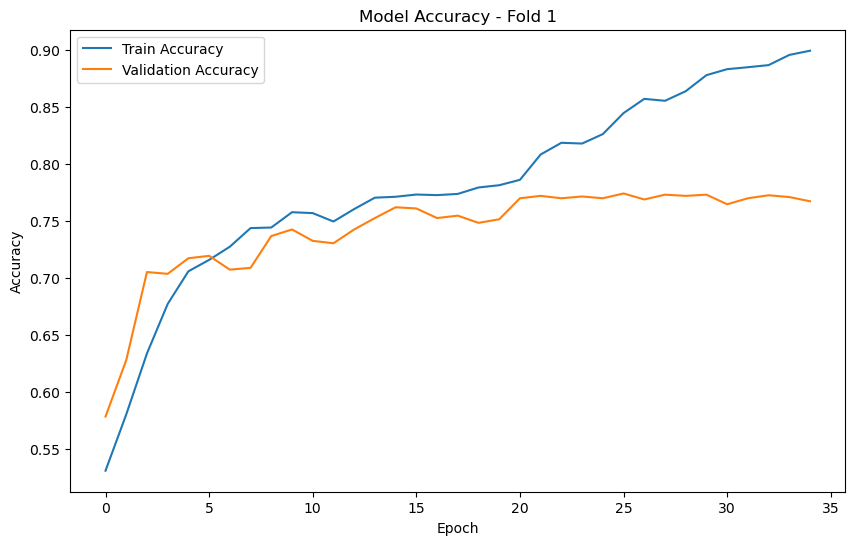

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 1 Results:
Accuracy: 0.7732
Balanced Accuracy: 0.7725
MCC: 0.5473
Sensitivity: 0.8143
Specificity: 0.7308

Learned track weights for fold 1:
Sequence weight: 0.6507
ProtT5 weight: 0.3493

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5221 - loss: 8.1124 - val_accuracy: 0.6189 - val_loss: 5.8220 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5777 - loss: 5.2788 - val_accuracy: 0.6300 - val_loss: 3.6227 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.6362 - loss: 3.2589 - val_accuracy: 0.6811 - val_loss: 2.2654 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6811 - loss: 2.0641 - val_accuracy: 0.7053 - val_loss: 1.5416 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.6888 - loss: 1.4450 - val_accuracy: 0.6605 - val_loss: 1.2199 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7009 - loss: 1.1261 - val_accuracy: 0.7321 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7088 - loss: 0.9807

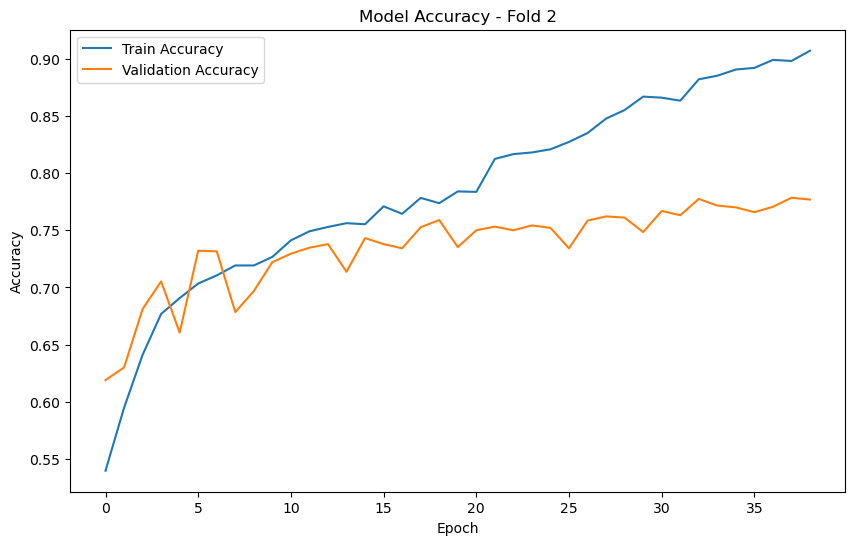

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7716
Balanced Accuracy: 0.7709
MCC: 0.5457
Sensitivity: 0.8273
Specificity: 0.7146

Learned track weights for fold 2:
Sequence weight: 0.6422
ProtT5 weight: 0.3578

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.5160 - loss: 8.0715 - val_accuracy: 0.6074 - val_loss: 5.7546 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5574 - loss: 5.2496 - val_accuracy: 0.6616 - val_loss: 3.5840 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.6134 - loss: 3.2348 - val_accuracy: 0.6953 - val_loss: 2.2382 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6699 - loss: 2.0528 - val_accuracy: 0.7058 - val_loss: 1.5168 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.6960 - loss: 1.4260 - val_accuracy: 0.7379 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.7020 - loss: 1.1239 - val_accuracy: 0.7137 - val_loss: 0.9600 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.7229 - loss: 0.9525

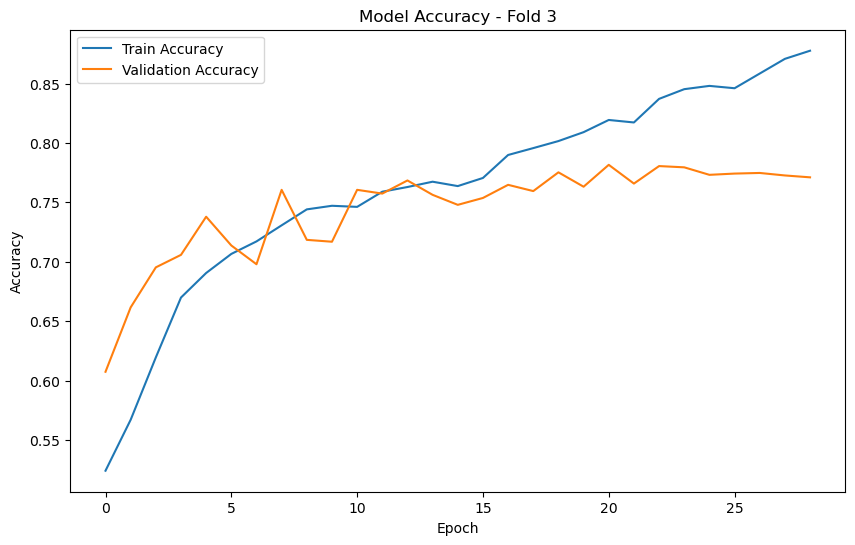

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Fold 3 Results:
Accuracy: 0.7795
Balanced Accuracy: 0.7792
MCC: 0.5601
Sensitivity: 0.8161
Specificity: 0.7423

Learned track weights for fold 3:
Sequence weight: 0.6206
ProtT5 weight: 0.3794

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.5169 - loss: 7.9427 - val_accuracy: 0.5816 - val_loss: 5.4426 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5721 - loss: 4.8628 - val_accuracy: 0.6105 - val_loss: 3.1953 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6322 - loss: 2.8342 - val_accuracy: 0.6816 - val_loss: 1.9594 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.6706 - loss: 1.7995 - val_accuracy: 0.6753 - val_loss: 1.3621 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.7092 - loss: 1.2637 - val_accuracy: 0.6847 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7177 - loss: 1.0294 - val_accuracy: 0.6884 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7226 - l

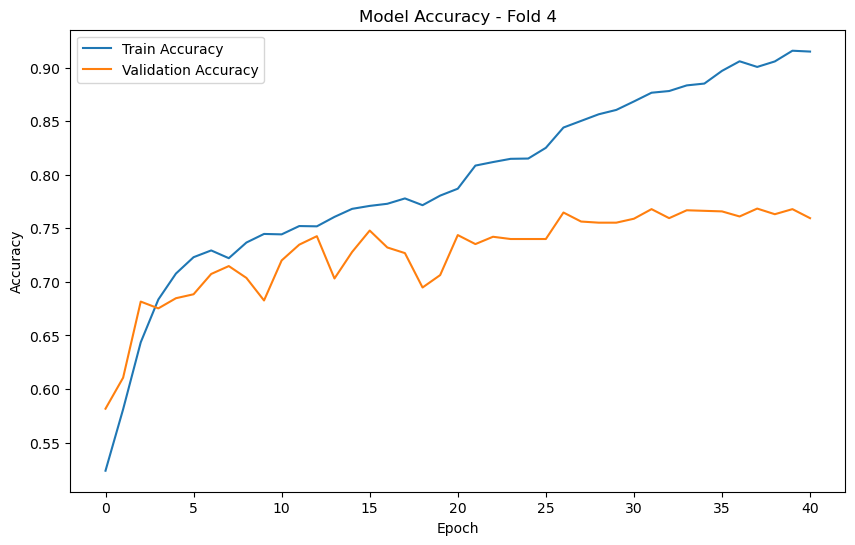

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 4 Results:
Accuracy: 0.7658
Balanced Accuracy: 0.7686
MCC: 0.5416
Sensitivity: 0.8448
Specificity: 0.6924

Learned track weights for fold 4:
Sequence weight: 0.6183
ProtT5 weight: 0.3817

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5248 - loss: 7.9391 - val_accuracy: 0.5958 - val_loss: 5.4145 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5798 - loss: 4.8424 - val_accuracy: 0.6321 - val_loss: 3.1604 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6315 - loss: 2.8241 - val_accuracy: 0.6721 - val_loss: 1.9356 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6848 - loss: 1.7757 - val_accuracy: 0.7058 - val_loss: 1.3270 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.7064 - loss: 1.2652 - val_accuracy: 0.6674 - val_loss: 1.0837 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.7051 - loss: 1.0329 - val_accuracy: 0.7158 - val_loss: 0.9387 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7285 - l

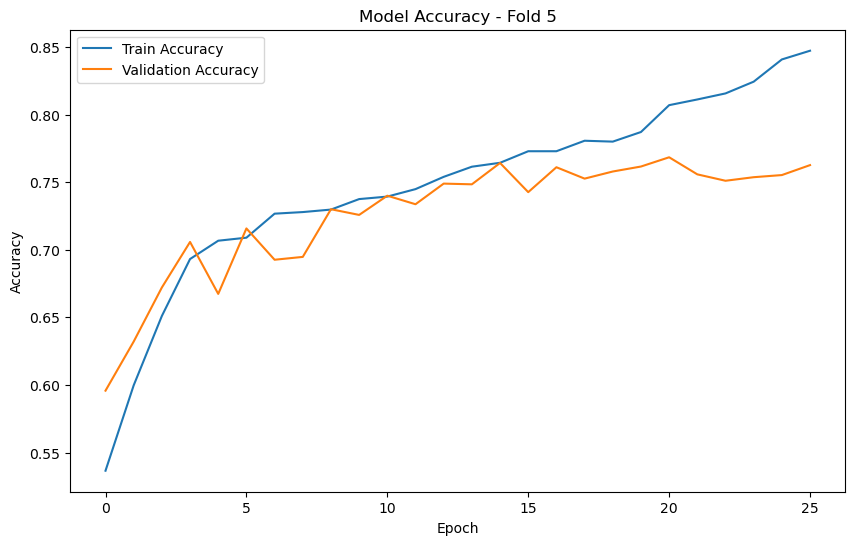

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 5 Results:
Accuracy: 0.7684
Balanced Accuracy: 0.7682
MCC: 0.5406
Sensitivity: 0.8290
Specificity: 0.7075

Learned track weights for fold 5:
Sequence weight: 0.6268
ProtT5 weight: 0.3732

Average track weights across folds:
Sequence weight: 0.6317 ± 0.0126
ProtT5 weight: 0.3683 ± 0.0126

Average Cross-validation Results:
ACC: 0.7717 ± 0.0047
BALANCED_ACC: 0.7719 ± 0.0040
MCC: 0.5471 ± 0.0070
SN: 0.8263 ± 0.0109
SP: 0.7175 ± 0.0175

Final Test Set Results:
Accuracy: 0.7370
Balanced Accuracy: 0.7958
MCC: 0.3410
Sensitivity: 0.8656
Specificity: 0.7260
Confusion Matrix:
[[2157  814]
 [  34  219]]


In [9]:
if __name__ == "__main__":
    model = train_and_evaluate()